<a href="https://colab.research.google.com/github/CwickHolmesalot/PowerDensity_AAPG2024/blob/main/AAPG01_PowerDensityEval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rethinking Power Density for Geothermal Resource Estimation<br>
## Script 1: Statistical evaluation of Power Density model<br>
Author: Chad Holmes<br>
Date: December 2024

### load libraries

In [ ]:
!pip install shap #--no-binary shap
!pip install jenkspy

In [ ]:
# load libraries
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import requests
import urllib.parse
import gc
import shap
import jenkspy
from pathlib import Path
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

### mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### load data

In [ ]:
path = r'drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG'
dirpath = Path(path)

In [ ]:
pd_orig = pd.read_excel(dirpath / 'Input' / 'PowerDensityPlot.xlsx')

### helper function to replicate Power Density model curves

In [ ]:
# predict from Wilmarth et al., 2021 equations, as implemented in RSAT tool
def PowerDensity_predict(restemp,maintrend):
  if maintrend == False:
    return 9.7
  else:
    return 0.4084*np.exp(0.0144*restemp)

### recreate power density plot

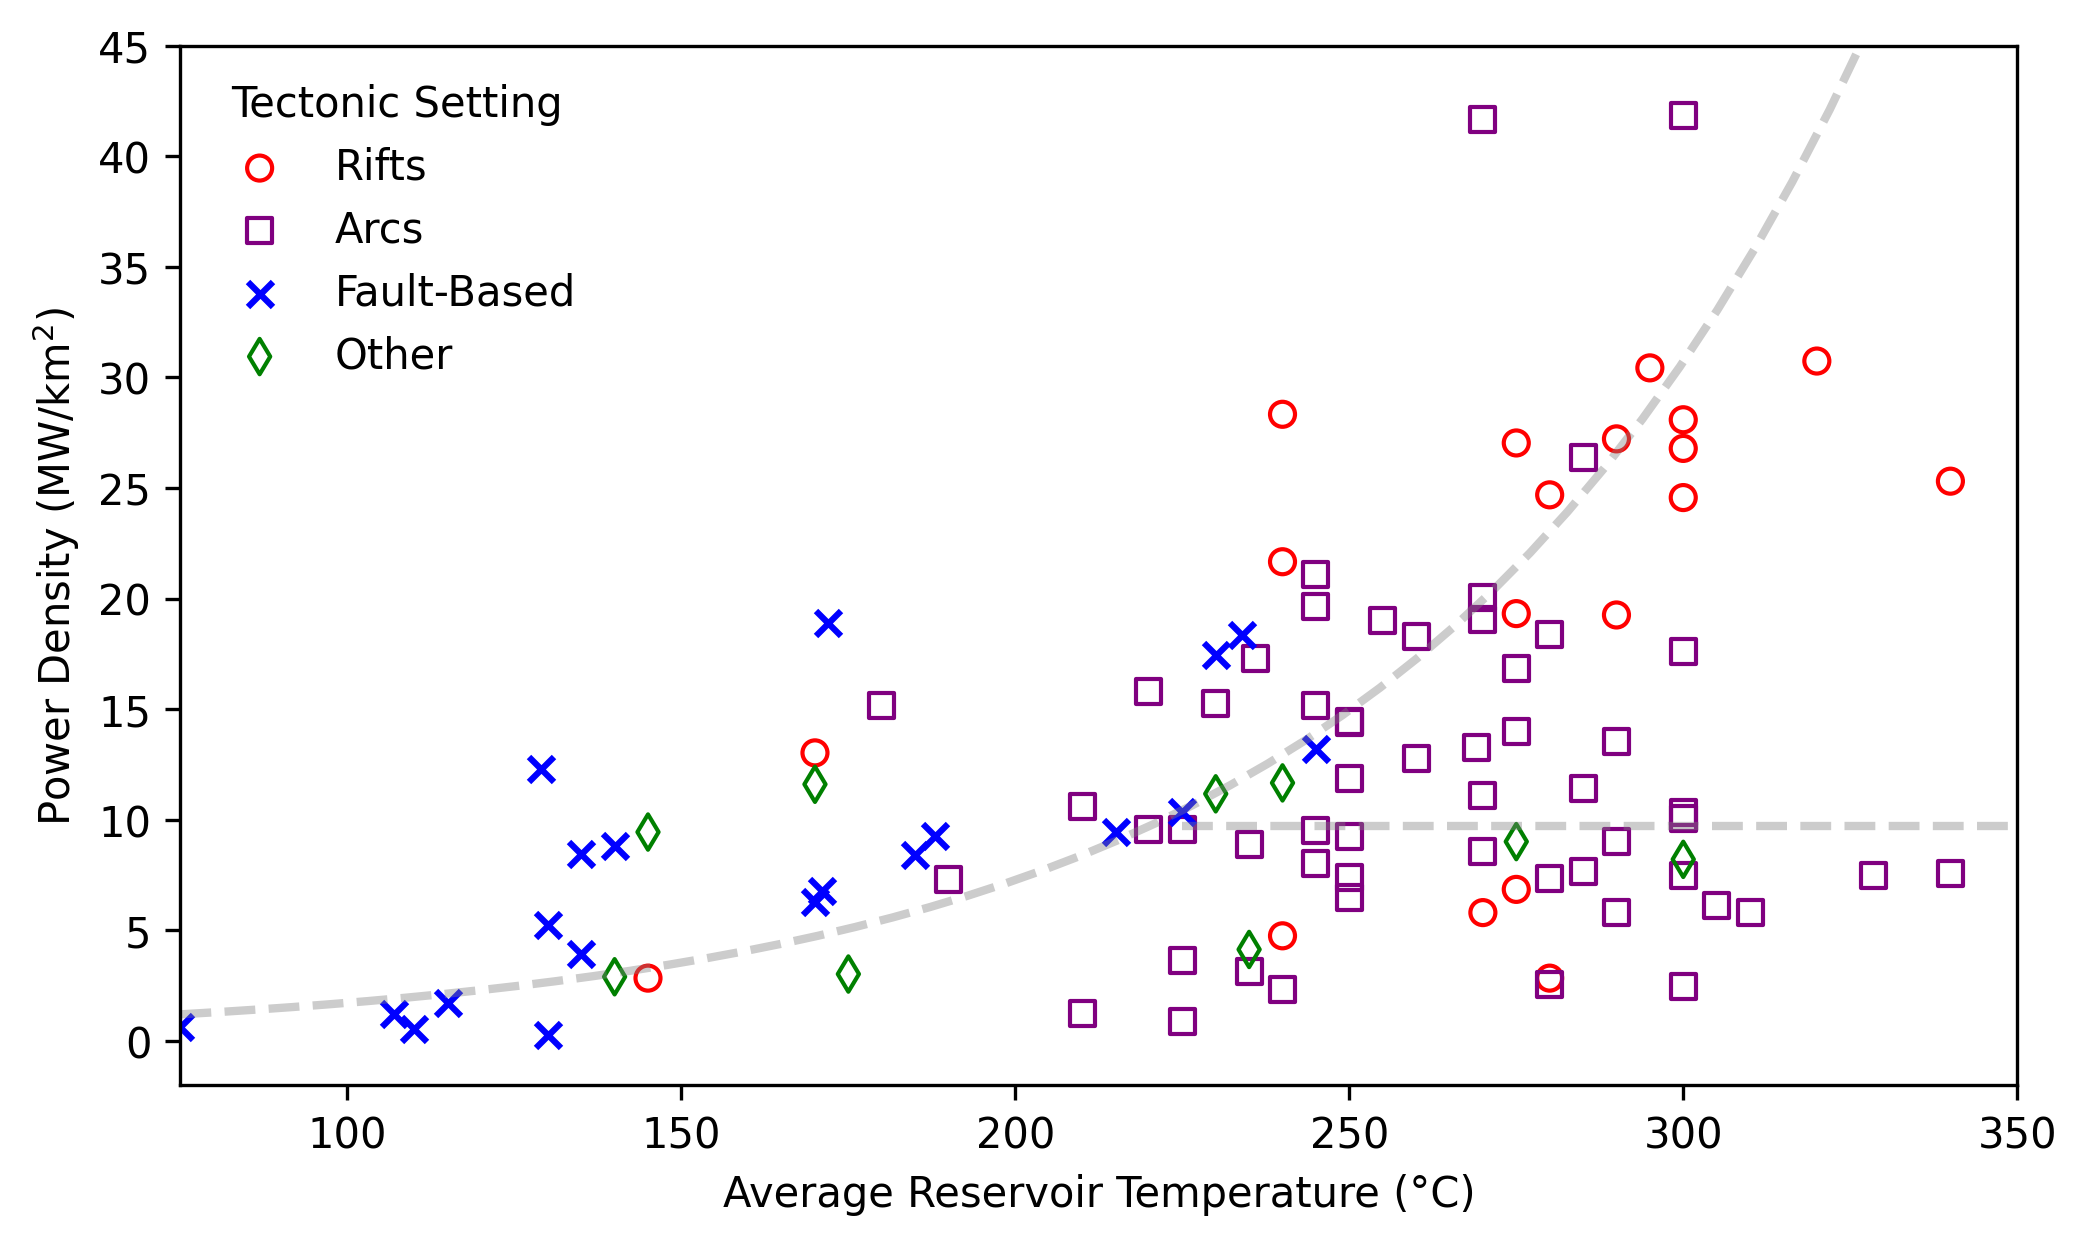

In [ ]:
plt.rcdefaults()
graphWidth = 790
graphHeight = 450
f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)

# create data for the fitted equation plot
xMT = np.linspace(pd_orig.WS_Temp.min(), pd_orig.WS_Temp.max()+10)
yMT = [PowerDensity_predict(x,True) for x in xMT]
xHA = np.linspace(225, pd_orig.WS_Temp.max()+10)
yHA = [PowerDensity_predict(x,False) for x in xHA]

# plot 2-curve model as a dashed line plot
plt.plot(xMT,yMT,color='gray',linestyle='dashed',linewidth=2, alpha=0.4)
plt.plot(xHA,yHA,color='gray',linestyle='dashed',linewidth=2, alpha=0.4)

# label flag
addlab = False

xcol   = 'WS_Temp'
ycol   = 'WS_PowerDensity'
labcol = 'Name'

# plot Rift fields
subset = pd_orig[pd_orig.WS_TectonicRegime == 'Rifts']
plt.scatter(subset[xcol], subset[ycol],
            color='red',marker='o',facecolors='none',label='Rifts')

if addlab:
  for i in range(subset.shape[0]):
      plt.annotate(subset[labcol].iloc[i],
                  (subset[xcol].iloc[i], subset[ycol].iloc[i]),
                  textcoords="offset points",xytext=(0,5),
                  va='bottom', ha='center', fontsize=5)

# plot Arc fields
subset = pd_orig[pd_orig.WS_TectonicRegime == 'Arcs']
plt.scatter(subset[xcol],subset[ycol],
            color='purple',marker='s',facecolors='none',label='Arcs')

if addlab:
  for i in range(subset.shape[0]):
      plt.annotate(subset[labcol].iloc[i],
                  (subset[xcol].iloc[i], subset[ycol].iloc[i]),
                  textcoords="offset points",xytext=(0,5),
                  va='bottom', ha='center', fontsize=5)

# plot Fault-Based fields fields
subset = pd_orig[pd_orig.WS_TectonicRegime == 'Fault-Based']
plt.scatter(subset[xcol],subset[ycol],
            color='blue',marker='x',label='Fault-Based')

if addlab:
  for i in range(subset.shape[0]):
      plt.annotate(subset[labcol].iloc[i],
                  (subset[xcol].iloc[i], subset[ycol].iloc[i]),
                  textcoords="offset points",xytext=(0,5),
                  va='bottom', ha='center', fontsize=5)


# plot Other fields
subset = pd_orig[pd_orig.WS_TectonicRegime == 'Other']
plt.scatter(subset[xcol],subset[ycol],
            color='green',marker='d',facecolors='none',label='Other')

if addlab:
  for i in range(subset.shape[0]):
      plt.annotate(subset[labcol].iloc[i],
                  (subset[xcol].iloc[i], subset[ycol].iloc[i]),
                  textcoords="offset points",xytext=(0,5),
                  va='bottom', ha='center', fontsize=5)

plt.legend(loc='upper left',title='Tectonic Setting',framealpha=0)
plt.ylabel('Power Density (MW/km$^{2}$)')
plt.xlabel('Average Reservoir Temperature (°C)')

# plt.gca().set_yscale("log")
plt.gca().set_ylim(-2,45)
plt.yticks(ticks=range(0,50,5))
plt.gca().set_xlim(75,350)
plt.show()

### helper functions to report results using key metrics

In [ ]:
def predict_and_report_results(model,x_test,y_test,x_train,y_train):
  pred_train = model.predict(x_train)
  pred_test  = model.predict(x_test)

  print('R^2 on test set:  ',round(r2_score(y_test,pred_test),2))
  print('R^2 on train set: ',round(r2_score(y_train,pred_train),2))
  print('MSE on test set:  ',round(mean_squared_error(y_test,pred_test),1))
  print('MSE on train set: ',round(mean_squared_error(y_train,pred_train),1))
  print('RMSE on test set:  ',round(root_mean_squared_error(y_test,pred_test),1))
  print('RMSE on train set: ',round(root_mean_squared_error(y_train,pred_train),1))

def short_report_results(y,yhat):
  print('R^2:  ',round(r2_score(y,yhat),2))
  print('MSE:  ',round(mean_squared_error(y,yhat),1))
  print('RMSE: ',round(root_mean_squared_error(y,yhat),1))

def short_report_results_by_setting(y, yhat, y_tsetting):

  # Overall results
  print('Overall Results:')
  print('R^2:  ',round(r2_score(y,yhat),2))
  print('MSE:  ',round(mean_squared_error(y,yhat),1))
  print('RMSE: ',round(root_mean_squared_error(y,yhat),1))

  # Unique tectonic settings
  tsettings = np.unique(y_tsetting)

  for tsetting in tsettings:
      print(f'\nResults for Tectonic Setting: {tsetting}')

      # Filter data by tectonic setting
      setting_mask = y_tsetting == tsetting
      y_setting_filtered = y[setting_mask]
      yhat_setting_filtered = yhat[setting_mask]

      # Calculate and print metrics
      print('R^2:  ',round(r2_score(y_setting_filtered,yhat_setting_filtered),2))
      print('MSE:  ',round(mean_squared_error(y_setting_filtered,yhat_setting_filtered),1))
      print('RMSE: ',round(root_mean_squared_error(y_setting_filtered,yhat_setting_filtered),1))

def report_results(y_train,pred_train,y_test,pred_test):
  print('R^2 on test set:  ',round(r2_score(y_test,pred_test),2))
  print('R^2 on train set: ',round(r2_score(y_train,pred_train),2))
  print('RMSE on test set:  ',round(root_mean_squared_error(y_test,pred_test),1))
  print('RMSE on train set: ',round(root_mean_squared_error(y_train,pred_train),1))

def report_results_by_setting(y_train, pred_train, y_test, pred_test, y_train_tsetting, y_test_tsetting):
  # Overall results
  print('Overall Results:')
  print('R^2 on test set:  ', round(r2_score(y_test, pred_test), 2))
  print('R^2 on train set: ', round(r2_score(y_train, pred_train), 2))
  print('RMSE on test set:  ', round(root_mean_squared_error(y_test, pred_test), 1))
  print('RMSE on train set: ', round(root_mean_squared_error(y_train, pred_train), 1))

  # Unique tectonic settings
  tsettings = np.unique(y_train_tsetting)

  for tsetting in tsettings:
      print(f'\nResults for Tectonic Setting: {tsetting}')

      # Filter data by tectonic setting
      train_mask = y_train_tsetting == tsetting
      test_mask = y_test_tsetting == tsetting

      y_train_tsetting_filtered = y_train[train_mask]
      pred_train_tsetting_filtered = pred_train[train_mask]
      y_test_tsetting_filtered = y_test[test_mask]
      pred_test_tsetting_filtered = pred_test[test_mask]

      # Calculate and print metrics
      print('R^2 on test set:  ', round(r2_score(y_test_tsetting_filtered, pred_test_tsetting_filtered), 2))
      print('R^2 on train set: ', round(r2_score(y_train_tsetting_filtered, pred_train_tsetting_filtered), 2))
      print('RMSE on test set:  ', round(root_mean_squared_error(y_test_tsetting_filtered, pred_test_tsetting_filtered), 1))
      print('RMSE on train set: ', round(root_mean_squared_error(y_train_tsetting_filtered, pred_train_tsetting_filtered), 1))

In [ ]:
# define cut-off to switch between "Main Trend" and "Hot Arcs"
hotarc_cutoff = 0.5

In [ ]:
# detect anomalies to separate out "Hot Arc" from "Arc"

# # reset flag for maintrend (make everything maintrend)
pd_orig.loc[:,'MainTrend'] = True

# predict using exponential fit line
pd_orig.loc[:,'Prediction'] = [PowerDensity_predict(t,True) for t in pd_orig.WS_Temp]

# calculate residuals (y-y_hat)
residuals = pd_orig.WS_PowerDensity-pd_orig.Prediction
pd_orig.loc[:,'Residuals'] = residuals

print('Prediction with just Main Trend curve:')
short_report_results_by_setting(pd_orig.WS_PowerDensity,pd_orig.Prediction,pd_orig.WS_TectonicRegime)
MAEr = np.mean(residuals)
STDr = np.std(residuals)
norm_residuals = (residuals)/STDr

# more than cutoff standard deviations away from the mean is considered an anomaly
pd_orig.loc[:,'ZScore'] = norm_residuals
#pd_orig.loc[:,'ZScore'] = [np.round(n,1) for n in norm_residuals]

# use cutoff to capture "Hot Arcs"
haindex = pd_orig[(pd_orig.WS_TectonicRegime == 'Arcs') & (pd_orig.ZScore <= -hotarc_cutoff)].index.tolist()
# print(haindex)
pd_orig.loc[haindex,'MainTrend'] = False

# refit prediction
pd_orig.loc[:,'Prediction'] = [PowerDensity_predict(t,h) for t,h in zip(pd_orig.WS_Temp,pd_orig.MainTrend)]
print('\nResults with 2-Curve Model, threshold:',hotarc_cutoff)
# short_report_results(pd_orig.WS_PowerDensity,pd_orig.Prediction)
short_report_results_by_setting(pd_orig.WS_PowerDensity,pd_orig.Prediction,pd_orig.WS_TectonicRegime)

pd_orig.loc[:,'TS_SigTest'] = pd_orig.WS_TectonicRegime
pd_orig.loc[pd_orig.MainTrend==False,'TS_SigTest'] = 'Hot Arc'
print('\nCount of different tectonic settings, including Hot Arcs')
print(pd_orig.TS_SigTest.value_counts())

# Welch t-test
from scipy.stats import ttest_ind
# normality assumed, use log of PD to make data normally-distributed
value_arrays = [pd_orig[pd_orig.MainTrend==c].WS_PowerDensity.apply(np.log) for c in [True, False]]
# Perform the t-test
t_val, p_val = ttest_ind(*value_arrays,equal_var=False)
print('\nWelch''s t-value:', round(t_val,4), 'p-value:', round(p_val,3))

# Mann-Whitney U test
from scipy.stats import mannwhitneyu
# normality not assumed, so no need for log transform
value_arrays = [pd_orig[pd_orig.MainTrend==c].WS_PowerDensity for c in [True, False]]
# Perform the Mann-Whitney U test
u_val, p_val = mannwhitneyu(*value_arrays)
print('\nMann-Whitney U-value:', round(u_val,4), 'p-value:', round(p_val,3))

# ANOVA
from scipy.stats import f_oneway
# normality assumed, use log of PD to make data normally-distributed
# value_arrays = [pd_orig[pd_orig.TS_SigTest==c].WS_PowerDensity.apply(np.log) for c in pd_orig.TS_SigTest.unique()]
value_arrays = [pd_orig[pd_orig.MainTrend==c].WS_PowerDensity.apply(np.log) for c in [True, False]]
f_val, p_val = f_oneway(*value_arrays)
print('\nANOVA F-value:', round(f_val,4), 'p-value:', round(p_val,3))

# Kruskal-Wallis
from scipy.stats import kruskal
# normality not assumed, so no need for log transform
# value_arrays = [pd_orig[pd_orig.TS_SigTest==c].WS_PowerDensity for c in  pd_orig.TS_SigTest.unique()]
value_arrays = [pd_orig[pd_orig.MainTrend==c].WS_PowerDensity for c in [True, False]]
h_val, p_val = kruskal(*value_arrays)
print('\nKruskal-Wallis H-value:', round(h_val,4), 'p-value:', round(p_val,3))

# Levene test
from scipy.stats import levene
# normality not assumed, so no need for log transform
value_arrays = [pd_orig[pd_orig.TS_SigTest==c].WS_PowerDensity for c in  pd_orig.TS_SigTest.unique()]
# Perform Levene's test
stat, p = levene(*value_arrays)
print(f"\nLevine statistic: {round(stat,4)}, p-value: {round(p,3)}")

print('\nResults with hot arc curve shifted, threshold:',hotarc_cutoff)
ha_meanpd = pd_orig[pd_orig.MainTrend == False].WS_PowerDensity.mean()
print(f'Hot Arc Avg Power Density: {round(ha_meanpd,2)}')
pd_orig.loc[(pd_orig.MainTrend==False),'Prediction'] = ha_meanpd
# short_report_results(pd_orig.WS_PowerDensity,pd_orig.Prediction)
short_report_results_by_setting(pd_orig.WS_PowerDensity,pd_orig.Prediction,pd_orig.WS_TectonicRegime)

Prediction with just Main Trend curve:
Overall Results:
R^2:   -1.0
MSE:   148.1
RMSE:  12.2

Results for Tectonic Setting: Arcs
R^2:   -2.27
MSE:   210.5
RMSE:  14.5

Results for Tectonic Setting: Fault-Based
R^2:   0.27
MSE:   23.8
RMSE:  4.9

Results for Tectonic Setting: Other
R^2:   -6.73
MSE:   90.4
RMSE:  9.5

Results for Tectonic Setting: Rifts
R^2:   -0.31
MSE:   125.7
RMSE:  11.2

Results with 2-Curve Model, threshold: 0.5
Overall Results:
R^2:   0.31
MSE:   50.9
RMSE:  7.1

Results for Tectonic Setting: Arcs
R^2:   0.56
MSE:   28.5
RMSE:  5.3

Results for Tectonic Setting: Fault-Based
R^2:   0.27
MSE:   23.8
RMSE:  4.9

Results for Tectonic Setting: Other
R^2:   -6.73
MSE:   90.4
RMSE:  9.5

Results for Tectonic Setting: Rifts
R^2:   -0.31
MSE:   125.7
RMSE:  11.2

Count of different tectonic settings, including Hot Arcs
TS_SigTest
Hot Arc        29
Arcs           26
Fault-Based    20
Rifts          19
Other           9
Name: count, dtype: int64

Welchs t-value: 2.8608 p-val

### make plot with std dev multiples color-coded

residual mean: -4.585786695115338, std: 11.272865278654834
norm residuals:  123.51118942829129


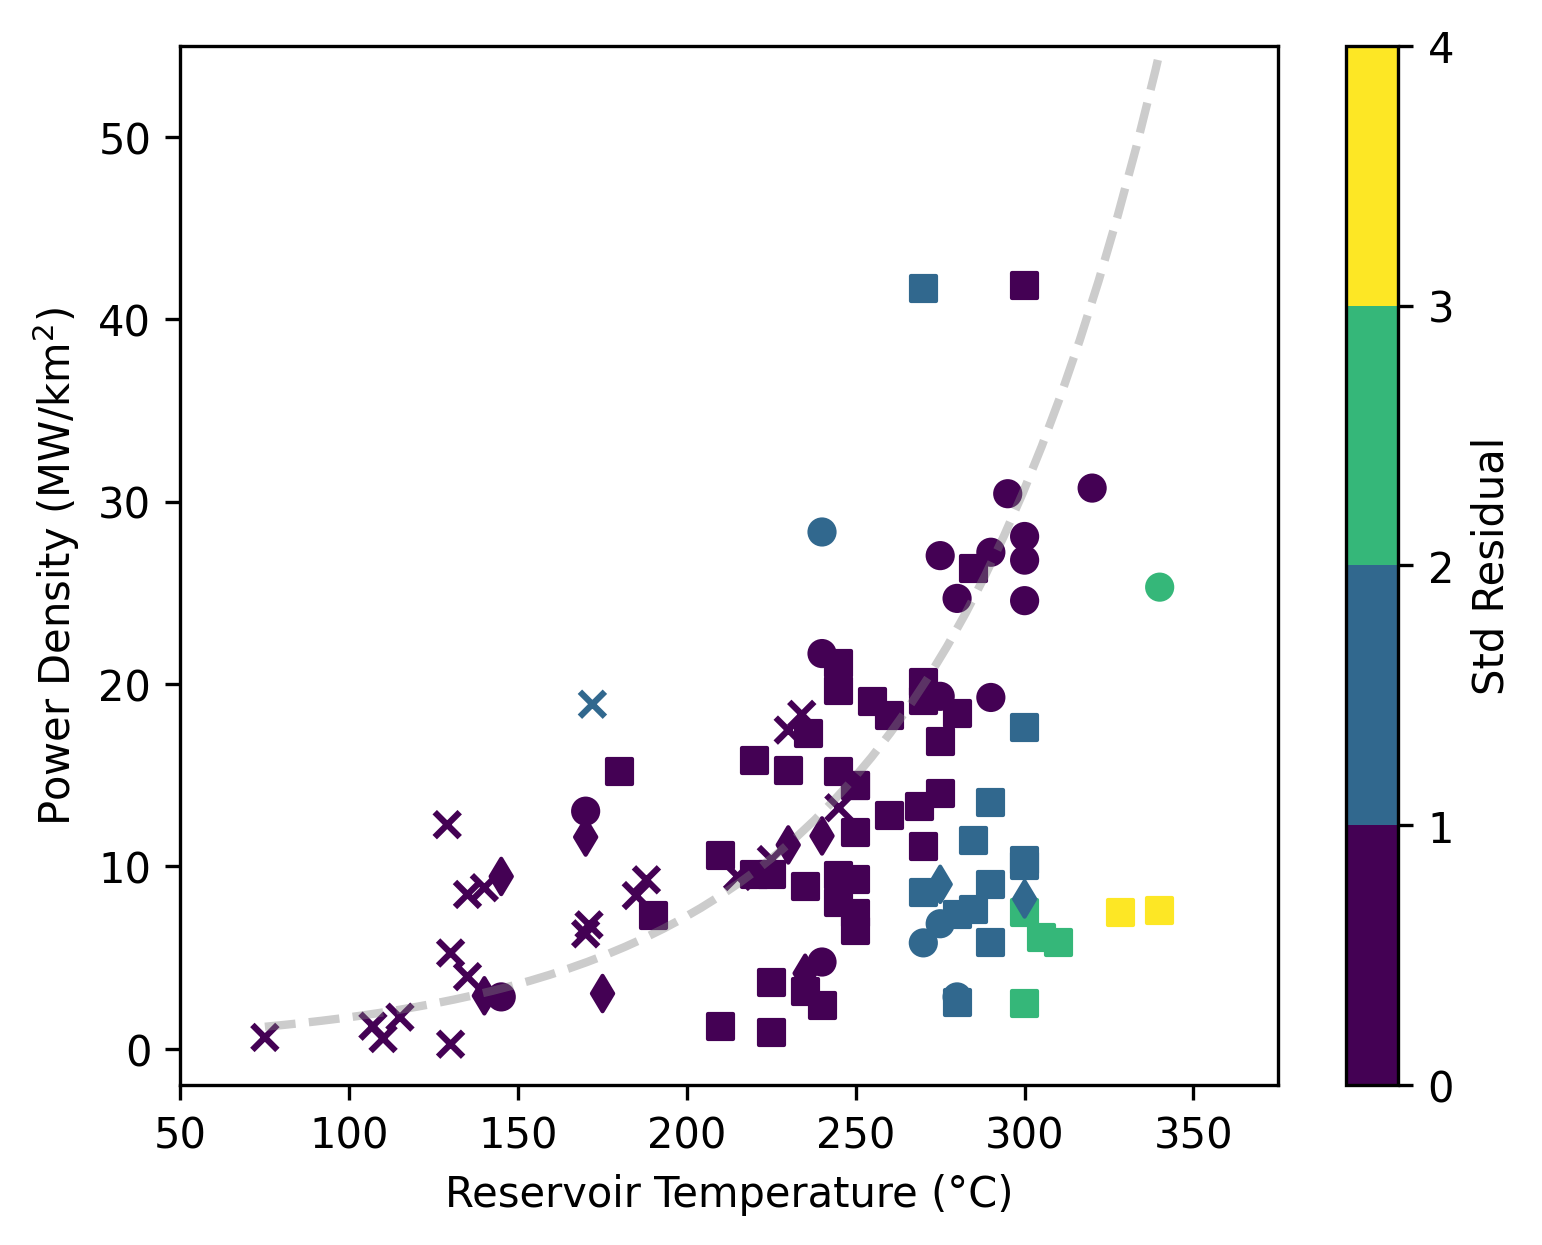

In [ ]:
from scipy.stats import zscore
import matplotlib as mpl

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# build color map
cmap = mpl.colors.ListedColormap(mpl.colormaps['viridis'](np.linspace(0, 1, 4)))
norm = mpl.colors.BoundaryNorm(boundaries=[0,1,2,3,4], ncolors=4)

# calculate residuals
singlepred = [PowerDensity_predict(t,True) for t in pd_orig.WS_Temp]
residuals  = pd_orig.WS_PowerDensity-singlepred
mean_residual = np.mean(residuals)
std_residual  = np.std(residuals)
norm_residuals = (residuals)/std_residual
print(f'residual mean: {mean_residual}, std: {std_residual}')
print('norm residuals: ',np.sqrt(np.sum(np.square(residuals))))

# generate residual plot
pdresults = pd_orig[['Name','WS_Temp','WS_PowerDensity','WS_TectonicRegime','Prediction','MainTrend']]
pdresults.columns = ['Name','Temp','PowerDensity','Regime','Prediction','MainTrend']
pdresults.loc[:,'Prediction'] = singlepred
pdresults.loc[:,'Residuals']  = residuals
pdresults.loc[:,'NormResid']  = norm_residuals
pdresults.loc[:,'AbsZscore']  = pdresults.NormResid.apply(abs)

# create plot layout
plt.rcdefaults()
graphWidth = 590
graphHeight = 450
f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
axes = f.add_subplot(111)

# create data for the fitted equation plot and plot
xMT = np.linspace(pdresults.Temp.min(), pdresults.Temp.max()+10)
yMT = [PowerDensity_predict(x,True) for x in xMT]
axes.plot(xMT,yMT,color='gray',linestyle='dashed',linewidth=2, alpha=0.4)

xcol = 'Temp'
ycol = 'PowerDensity'
ccol = 'AbsZscore'

# plt.scatter(pdresults['Temp'],pdresults['Prediction'],c='red',marker='o')

# plot points using same symbology as other plots
ind = (pdresults.Regime == 'Rifts')
plt.scatter(pdresults[ind][xcol],pdresults[ind][ycol],
            c=pdresults[ind][ccol], cmap=cmap, norm=norm,
            label='Rifts',marker='o',facecolors='white') #color='red'

ind = (pdresults.Regime == 'Arcs')
plt.scatter(pdresults[ind][xcol],pdresults[ind][ycol],
            c=pdresults[ind][ccol], cmap=cmap, norm=norm,
            label='Arcs',marker='s',facecolors='none') #color='purple'

ind = (pdresults.Regime == 'Fault-Based')
plt.scatter(pdresults[ind][xcol],pdresults[ind][ycol],
            c=pdresults[ind][ccol], cmap=cmap, norm=norm,
            label='Fault-Based',marker='x') #color='blue',

ind = (pdresults.Regime == 'Other')
sc = plt.scatter(pdresults[ind][xcol],pdresults[ind][ycol],
            c=pdresults[ind][ccol], cmap=cmap, norm=norm,
            label='Other',marker='d',facecolors='white') #color='green'

# Create a colorbar
plt.colorbar(sc, ticks=[0,1,2,3,4], label='Std Residual')

# plt.legend(loc='upper left',title='Tectonic Setting',framealpha=0)
axes.set_xlabel('Reservoir Temperature (°C)')
axes.set_ylabel('Power Density (MW/km$^{2}$)')

axes.set_ylim(-2,55)
axes.set_xlim(50,375)

plt.show()
plt.close('all') # clean up after using pyplot

### make plot of residuals about the mean

mean of all points: 12.367016217188036


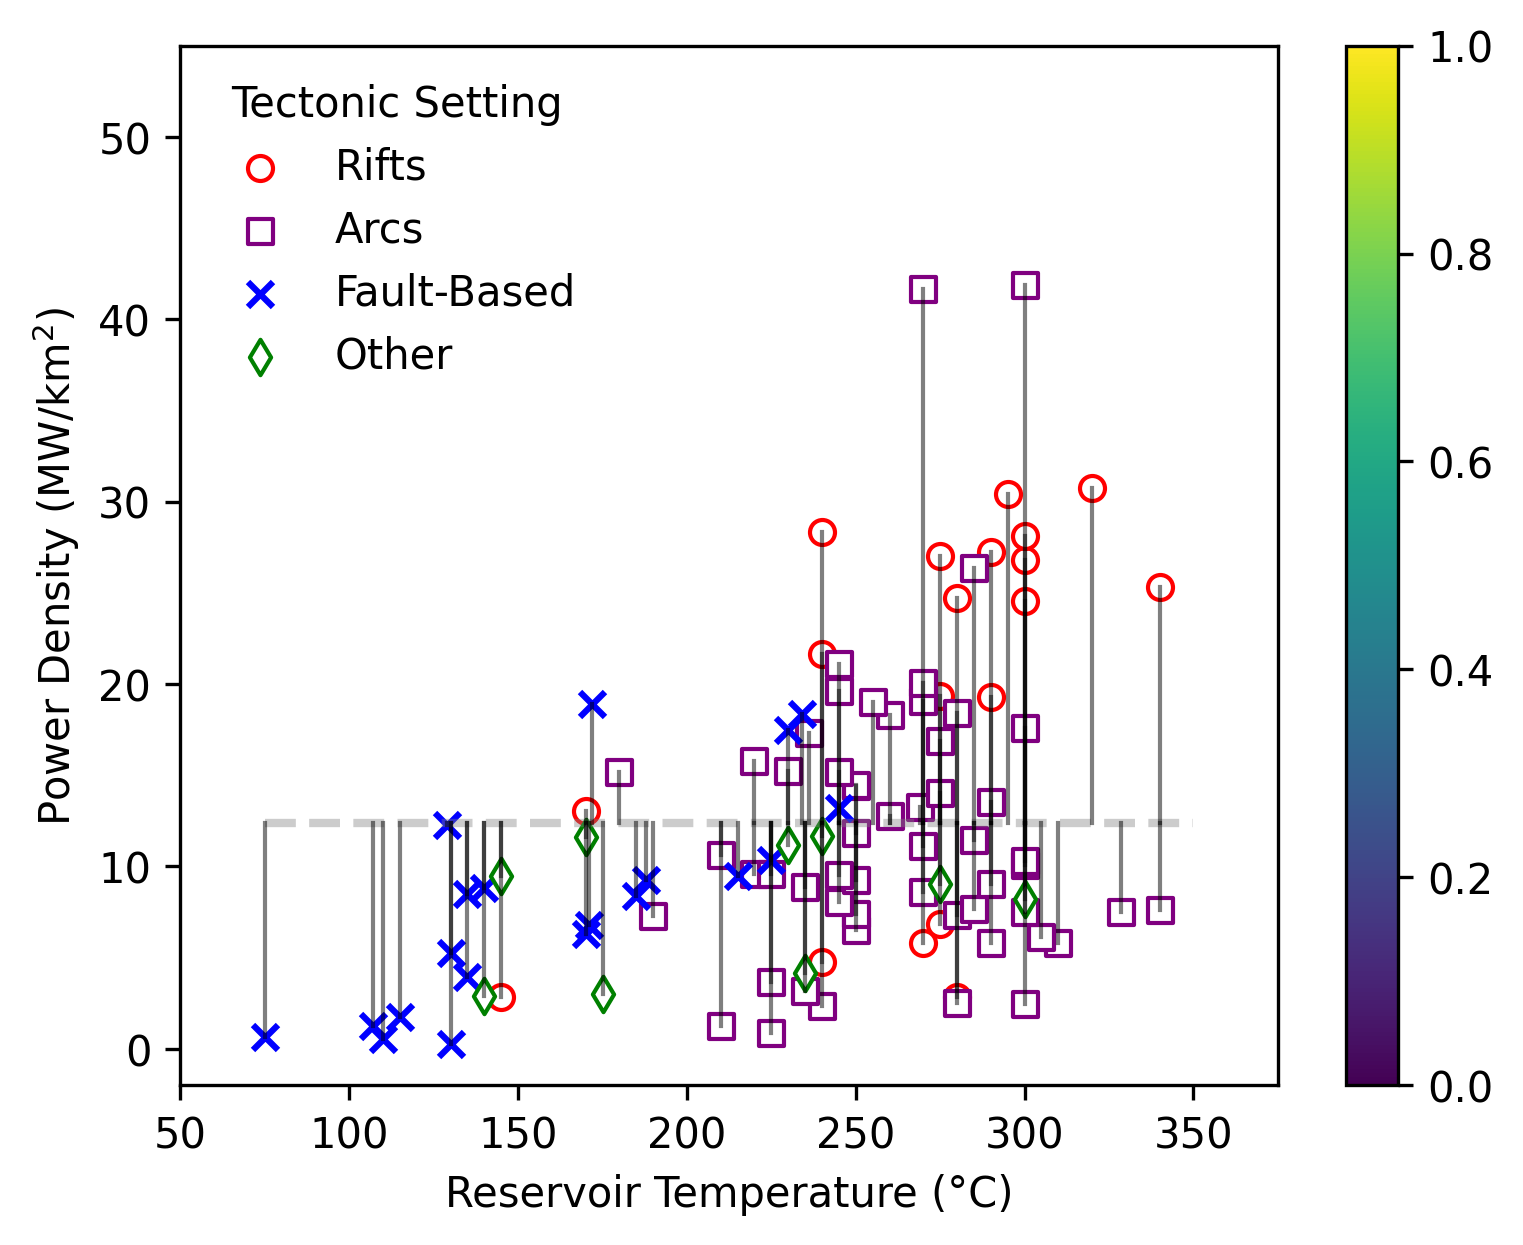

In [ ]:
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

all_meanpd = pdresults.PowerDensity.mean()
print('mean of all points:',all_meanpd)

# create plot layout
plt.rcdefaults()
graphWidth = 590
graphHeight = 450
f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
axes = f.add_subplot(111)

x = np.linspace(pdresults.Temp.min(), pdresults.Temp.max()+10)
y = [all_meanpd for v in x]

# plot MEAN model as a line plot
axes.plot(x,y,color='gray',linestyle='dashed',linewidth=2, alpha=0.4)

# add individual line for each point (main trend)
tmpdf = pdresults.reset_index()
for i in range(tmpdf.shape[0]):
  lineXdata = (tmpdf.Temp[i], tmpdf.Temp[i]) # same X
  lineYdata = (tmpdf.PowerDensity[i], all_meanpd) # different Y
  plt.plot(lineXdata, lineYdata, 'k-', linewidth=1, alpha=0.5)

# plot points using same symbology as other plots
ind = (pdresults.Regime == 'Rifts')
plt.scatter(pdresults[ind].Temp,pdresults[ind].PowerDensity,
            color='red',marker='o',facecolors='white',label='Rifts')

ind = (pdresults.Regime == 'Arcs')
plt.scatter(pdresults[ind].Temp,pdresults[ind].PowerDensity,
            color='purple',marker='s',facecolors='white',label='Arcs')

ind = (pdresults.Regime == 'Fault-Based')
plt.scatter(pdresults[ind].Temp,pdresults[ind].PowerDensity,
            color='blue',marker='x',label='Fault-Based')

ind = (pdresults.Regime == 'Other')
plt.scatter(pdresults[ind].Temp,pdresults[ind].PowerDensity,
            color='green',marker='d',facecolors='white',label='Other')

plt.legend(loc='upper left',title='Tectonic Setting',framealpha=0)
axes.set_xlabel('Reservoir Temperature (°C)')
axes.set_ylabel('Power Density (MW/km$^{2}$)')

axes.set_ylim(-2,55)
axes.set_xlim(50,375)
plt.colorbar()

plt.show()
plt.close('all') # clean up after using pyplot

### make plot of residuals about the 2-curve model

mean of Hot Arcs: 7.639421030225614
mean of all points: 12.367016217188036


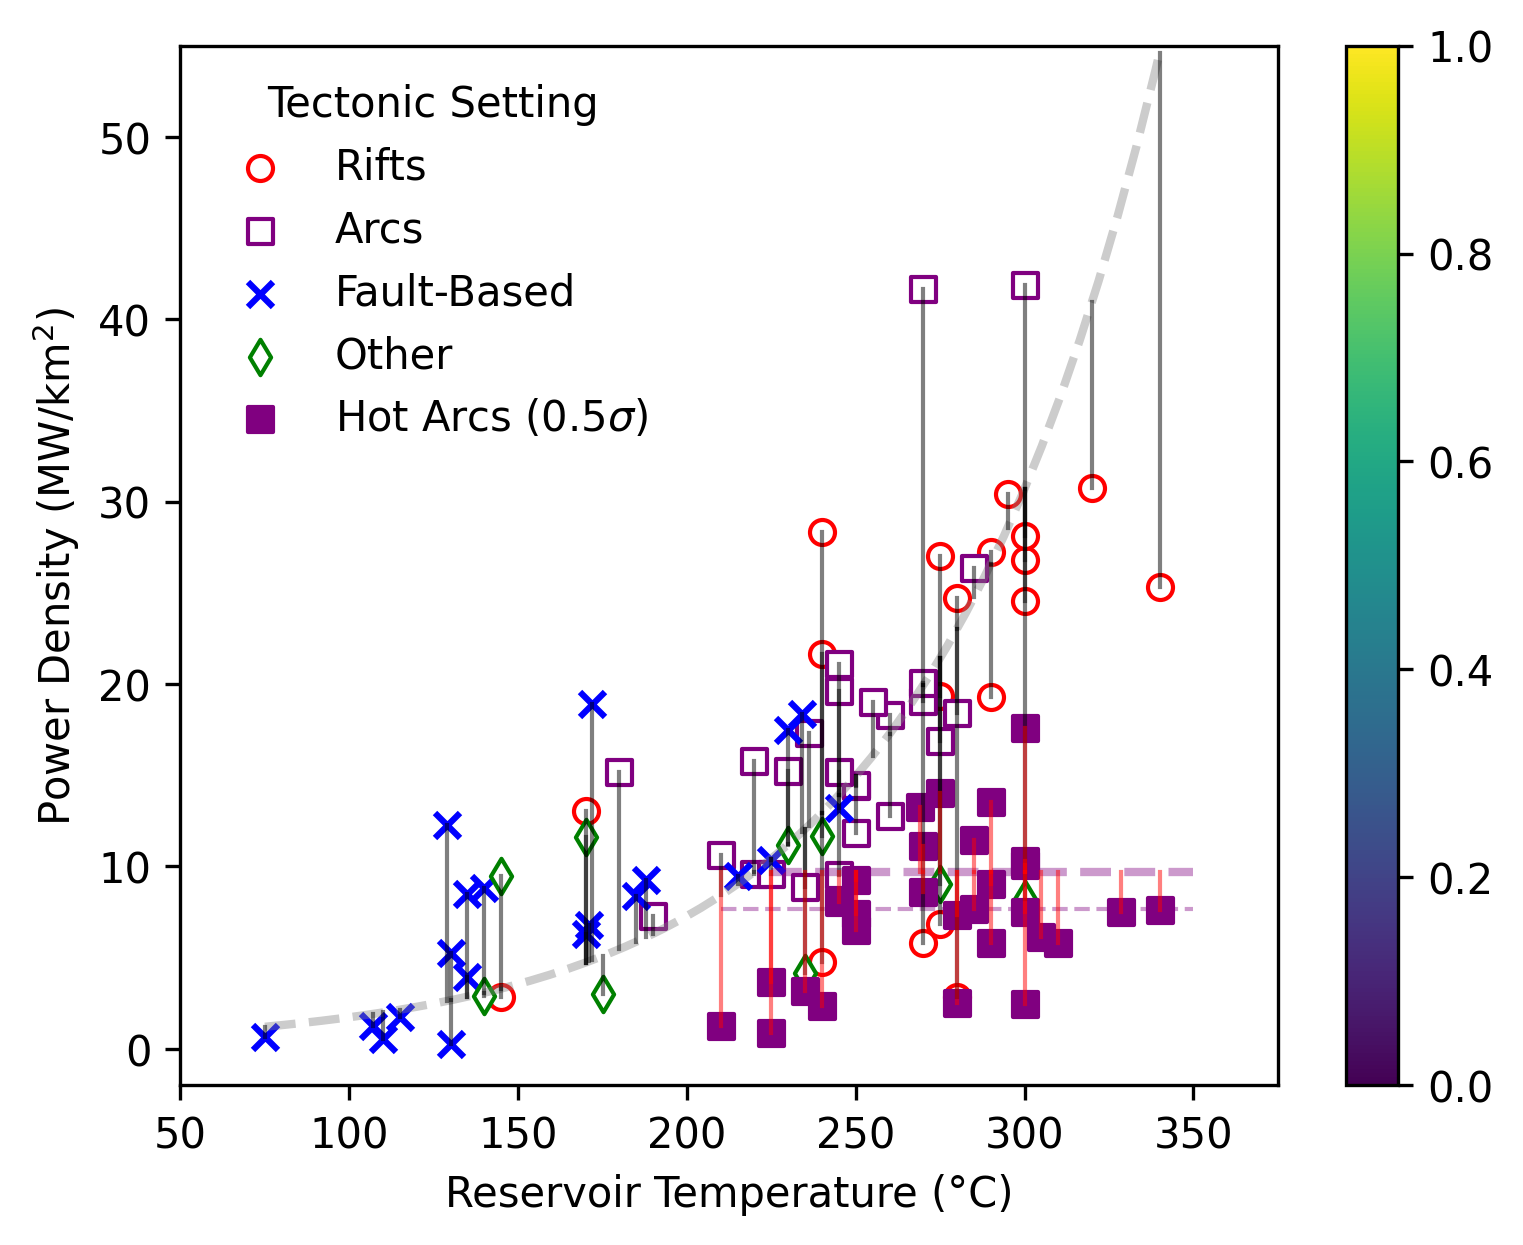

In [ ]:
# generate 2-curve residual plot

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

all_meanpd = pdresults.PowerDensity.mean()
ha_meanpd = pdresults[pdresults.MainTrend==False].PowerDensity.mean()
print('mean of Hot Arcs:',ha_meanpd)
print('mean of all points:',all_meanpd)

# create plot layout
plt.rcdefaults()
graphWidth = 590
graphHeight = 450
f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
axes = f.add_subplot(111)

# create data for the fitted equation plot
xMT = np.linspace(pdresults.Temp.min(), pdresults.Temp.max()+10)
yMT = [PowerDensity_predict(x,True) for x in xMT] #0.4084*np.exp(0.0144*xMT)
xHA = np.linspace(225, pdresults.Temp.max()+10)
yHA = [PowerDensity_predict(x,False) for x in xHA] #xHA*0+9.7
xHA2 = np.linspace(210, pdresults.Temp.max()+10)
yHA2 = xHA*0+ha_meanpd

# plot model as a line plot
axes.plot(xMT,yMT,color='gray',linestyle='dashed',linewidth=2, alpha=0.4)
axes.plot(xHA,yHA,color='purple',linestyle='dashed',linewidth=2, alpha=0.4)
axes.plot(xHA2,yHA2,color='purple',linestyle='dashed',linewidth=1, alpha=0.4)

# add individual line for each point (main trend)
tmpdf = pdresults[pdresults.MainTrend == True].reset_index()
for i in range(tmpdf.shape[0]):
  lineXdata = (tmpdf.Temp[i], tmpdf.Temp[i]) # same X
  lineYdata = (tmpdf.PowerDensity[i], tmpdf.Prediction[i]) # different Y
  plt.plot(lineXdata, lineYdata, 'k-', linewidth=1, alpha=0.5)

# add individual line for each point (hot arcs)
tmpdf = pdresults[pdresults.MainTrend == False].reset_index()
for i in range(tmpdf.shape[0]):
  lineXdata = (tmpdf.Temp[i], tmpdf.Temp[i]) # same X
  lineYdata = (tmpdf.PowerDensity[i], 9.7) # different Y
  plt.plot(lineXdata, lineYdata,'r-', linewidth=1, alpha=0.5)

# plot points using same symbology as other plots
ind = (pdresults.Regime == 'Rifts')
plt.scatter(pdresults[ind].Temp,pdresults[ind].PowerDensity,
            color='red',marker='o',facecolors='white',label='Rifts')

ind = ((pdresults.MainTrend == True) & (pdresults.Regime == 'Arcs'))
plt.scatter(pdresults[ind].Temp,pdresults[ind].PowerDensity,
            color='purple',marker='s',facecolors='white',label='Arcs')

ind = (pdresults.Regime == 'Fault-Based')
plt.scatter(pdresults[ind].Temp,pdresults[ind].PowerDensity,
            color='blue',marker='x',label='Fault-Based')

ind = (pdresults.Regime == 'Other')
plt.scatter(pdresults[ind].Temp,pdresults[ind].PowerDensity,
            color='green',marker='d',facecolors='white',label='Other')

# show hot arc points as filled squares
ind = pdresults.MainTrend == False
plt.scatter(pdresults[ind].Temp,pdresults[ind].PowerDensity,
            color='purple',marker='s',facecolors='purple',label=f"Hot Arcs ({hotarc_cutoff}$\\sigma$)")

plt.legend(loc='upper left',title='Tectonic Setting',framealpha=0)
axes.set_xlabel('Reservoir Temperature (°C)')
axes.set_ylabel('Power Density (MW/km$^{2}$)')

axes.set_ylim(-2,55)
axes.set_xlim(50,375)
plt.colorbar()

plt.show()
plt.close('all') # clean up after using pyplot


In [ ]:
pdresults.shape

(103, 9)

In [ ]:
# re-predict using MainTrend flag
pdpred = [PowerDensity_predict(t,h) for t,h in zip(pd_orig.WS_Temp,pd_orig.MainTrend)]
print('R^2:  ',round(r2_score(pd_orig.WS_PowerDensity,pdpred),4))
print('MSE:  ',round(mean_squared_error(pd_orig.WS_PowerDensity,pdpred),1))
print('RMSE:  ',round(root_mean_squared_error(pd_orig.WS_PowerDensity,pdpred),1))

# create results dataframe
pdresults = pd.DataFrame({'PowerDensity':pd_orig.WS_PowerDensity,'Temp':pd_orig.WS_Temp,
                            'MainTrend':pd_orig.MainTrend,'Prediction':pdpred,'Regime':pd_orig.WS_TectonicRegime})
# pdresults.to_excel(dirpath / 'PowerDensityMethod-LineFitResults.xlsx')

R^2:   0.3117
MSE:   50.9
RMSE:   7.1


In [ ]:
pdresults

,PowerDensity,Temp,MainTrend,Prediction,Regime
0,0.864198,225.0,False,9.700000,Arcs
1,1.234568,210.0,False,9.700000,Arcs
2,2.345679,240.0,False,9.700000,Arcs
3,2.469136,300.0,False,9.700000,Arcs
4,2.530864,280.0,False,9.700000,Arcs
...,...,...,...,...,...
98,27.222222,290.0,True,26.588846,Rifts
99,28.086420,300.0,True,30.707036,Rifts
100,28.333333,240.0,True,12.942181,Rifts
101,30.432099,295.0,True,28.573846,Rifts


### some additional stats checks

In [ ]:
# for the main trend only (dropping hot arc points)
absError = pdresults[pdresults.MainTrend==True].Prediction-pdresults[pdresults.MainTrend==True].PowerDensity
SE = np.square(absError) # squared errors
MSE = np.mean(SE)        # mean squared errors
RMSE = np.sqrt(MSE)      # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.sum(SE) / np.sum((pdresults.PowerDensity-pdresults.PowerDensity.mean())**2))
print('RMSE:', round(RMSE,1))
print('R-squared:', round(Rsquared,2))
print('average Hot Arc power density:', round(pdresults[pdresults.MainTrend==False].PowerDensity.mean(),2))

RMSE: 7.9
R-squared: 0.39
average Hot Arc power density: 7.64


In [ ]:
# for the different hot arc mean
pred = [ha_meanpd if p == 9.7 else p for p in pdresults.Prediction]
absError = pred-pdresults.PowerDensity
SE = np.square(absError) # squared errors
MSE = np.mean(SE)        # mean squared errors
RMSE = np.sqrt(MSE)      # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.sum(SE) / np.sum((pdresults.PowerDensity-pdresults.PowerDensity.mean())**2))
print('RMSE:', round(RMSE,1))
print('R-squared:', round(Rsquared,2))
print(f'average Hot Arc power density: {round(ha_meanpd,2)}')

RMSE: 7.1
R-squared: 0.33
average Hot Arc power density: 7.64


### Look at separability of tectonic classes

#### student t-test to test if the means come from different distributions

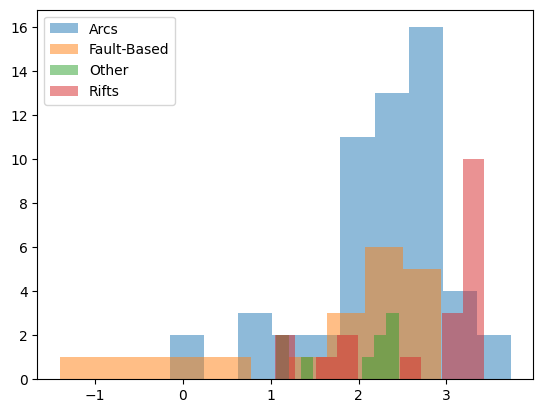

In [ ]:
for group in pd_orig.groupby(by='WS_TectonicRegime'):
    plt.hist(np.log(group[1].WS_PowerDensity),alpha=0.5)
plt.legend(pd_orig.WS_TectonicRegime.unique())
plt.show()

In [ ]:
pd_orig.WS_TectonicRegime.value_counts()

,count
WS_TectonicRegime,
Arcs,55
Fault-Based,20
Rifts,19
Other,9


                 Arcs Fault-Based     Other     Rifts
Arcs              1.0    0.036351  0.150289   0.04078
Fault-Based  0.036351         1.0   0.33805   0.00228
Other        0.150289     0.33805       1.0  0.007654
Rifts         0.04078     0.00228  0.007654       1.0
                 Arcs  Fault-Based     Other     Rifts
Arcs         1.000000     0.006728  0.211803  0.028337
Fault-Based  0.006728     1.000000  0.459120  0.002306
Other        0.211803     0.459120  1.000000  0.015633
Rifts        0.028337     0.002306  0.015633  1.000000
                 Arcs Fault-Based     Other     Rifts
Arcs              1.0    0.455975  0.176762  0.178745
Fault-Based  0.455975         1.0   0.19363  0.082014
Other        0.176762     0.19363       1.0  0.064798
Rifts        0.178745    0.082014  0.064798       1.0
                 Arcs Fault-Based     Other     Rifts
Arcs              1.0    0.033446  0.150196  0.005789
Fault-Based  0.033446         1.0  0.813641  0.000961
Other        0.150196  

<ipython-input-81-1c01ac5be13f>:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Fmatdf = pd.DataFrame(F_matrix, index=tr_vals, columns=tr_vals).fillna(1.0)


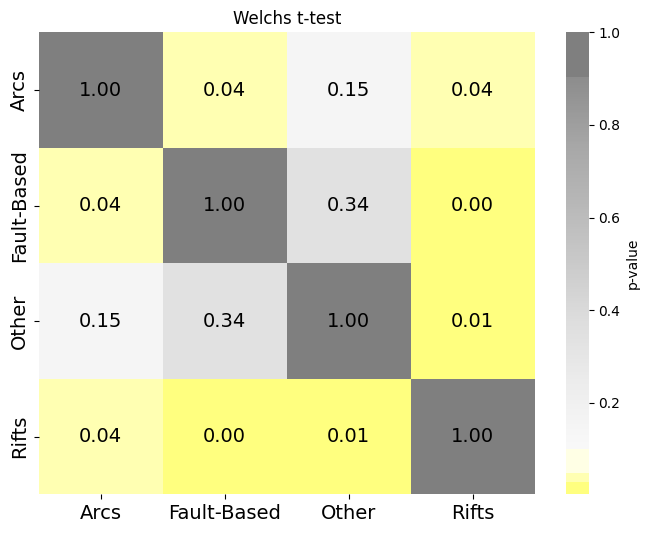

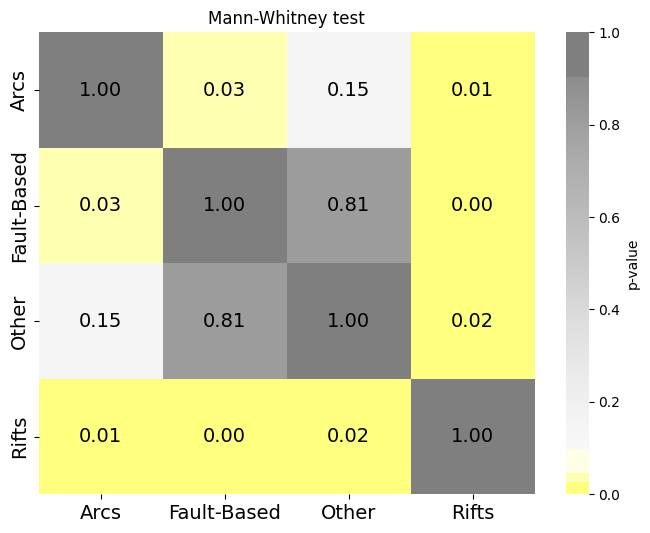

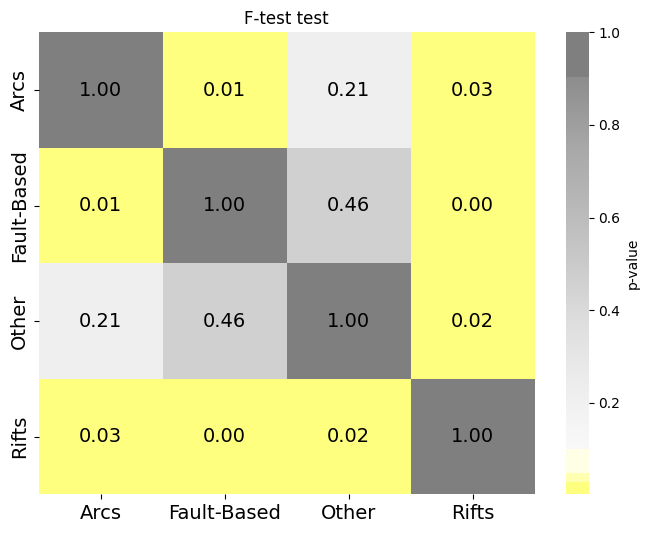

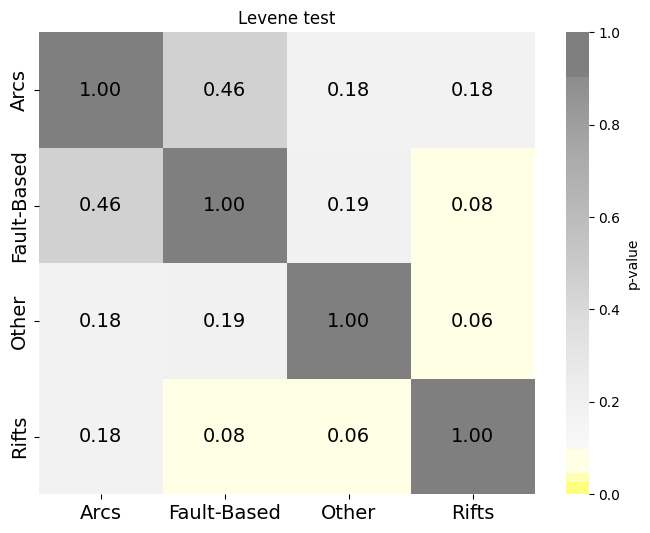

In [ ]:
from scipy.stats import ttest_ind,f_oneway,levene,fligner

tr_vals = pd_orig.WS_TectonicRegime.unique().tolist()

# Create an empty DataFrame to store the p-values
F_matrix = pd.DataFrame(index=tr_vals, columns=tr_vals)
t_matrix = F_matrix.copy(deep=True)
L_matrix = F_matrix.copy(deep=True)
M_matrix = F_matrix.copy(deep=True)

# Perform pairwise F-tests
for i in tr_vals:
    for j in tr_vals:

        # run student's t-test (Welch's version)
        t_matrix.loc[i, j] = ttest_ind(pd_orig[pd_orig.WS_TectonicRegime==i].WS_PowerDensity.apply(np.log),
                                       pd_orig[pd_orig.WS_TectonicRegime==j].WS_PowerDensity.apply(np.log),
                                       equal_var=False).pvalue # use Welch's t-test - don't assume variances are the same
        M_matrix.loc[i,j] = mannwhitneyu(pd_orig[pd_orig.WS_TectonicRegime==i].WS_PowerDensity,
                                         pd_orig[pd_orig.WS_TectonicRegime==j].WS_PowerDensity).pvalue
        F_matrix.loc[i, j] = f_oneway(pd_orig[pd_orig.WS_TectonicRegime==i].WS_PowerDensity.apply(np.log),
                                      pd_orig[pd_orig.WS_TectonicRegime==j].WS_PowerDensity.apply(np.log)).pvalue
        L_matrix.loc[i,j] = levene(pd_orig[pd_orig.WS_TectonicRegime==i].WS_PowerDensity,
                                   pd_orig[pd_orig.WS_TectonicRegime==j].WS_PowerDensity).pvalue
tmatdf = pd.DataFrame(t_matrix, index=tr_vals, columns=tr_vals)
Fmatdf = pd.DataFrame(F_matrix, index=tr_vals, columns=tr_vals).fillna(1.0)
Lmatdf = pd.DataFrame(L_matrix, index=tr_vals, columns=tr_vals)
Mmatdf = pd.DataFrame(M_matrix, index=tr_vals, columns=tr_vals)
print(tmatdf)
print(Fmatdf)
print(Lmatdf)
print(Mmatdf)

# Create the color palette
colors = mpl.colormaps['Greys'](np.linspace(0, 1, 256))
colors[:int(256*0.10), :] =  [1, 1, .8, 1] # RGBA for yellow
colors[:int(256*0.05), :] =  [1, 1, .4, 1] # RGBA for yellow
colors[:int(256*0.03), :] =  [1, 1, 0, 1]  # RGBA for yellow
colors[-int(256*0.10):, :] = [0, 0, 0, 1]  # blank out white
cmap = mpl.colors.ListedColormap(colors)

plt.figure(figsize=(8,6))
sns.heatmap(tmatdf.astype(float),
            annot=True,
            cmap=cmap,
            alpha=0.5,
            cbar_kws={'label':'p-value'},
            annot_kws={'color':'black', 'fontsize':14},
            fmt='.2f')
plt.title('Welchs t-test')
plt.gca().tick_params(axis='both',which='major',labelsize=14)
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(Mmatdf.astype(float),
            annot=True,
            cmap=cmap,
            # mask=diag_cells,
            vmin=0,vmax=1,
            alpha=0.5,
            cbar_kws={'label':'p-value'},
            annot_kws={'color':'black', 'fontsize':14},
            fmt='.2f')
plt.title('Mann-Whitney test')
plt.gca().tick_params(axis='both',which='major',labelsize=14)
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(Fmatdf.astype(float),
            annot=True,
            cmap=cmap,
            # mask=diag_cells,
            alpha=0.5,
            cbar_kws={'label':'p-value'},
            annot_kws={'color':'black', 'fontsize':14},
            fmt='.2f')
plt.title('F-test test')
plt.gca().tick_params(axis='both',which='major',labelsize=14)
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(Lmatdf.astype(float),
            annot=True,
            cmap=cmap,
            # mask=diag_cells,
            vmin=0,vmax=1,
            alpha=0.5,
            cbar_kws={'label':'p-value'},
            annot_kws={'color':'black', 'fontsize':14},
            fmt='.2f')
plt.title('Levene test')
plt.gca().tick_params(axis='both',which='major',labelsize=14)
plt.show()